# BO-SI Injection analysis

Notebook for collect injections data after and before the emittance exchange and compare the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime, date

rcParams.update({'font.size': 22, 'lines.linewidth': 1, 'text.usetex':True})

from siriuspy.clientarch import PVData, PVDataSet, Time
# %matplotlib qt5

Useful functions

In [2]:
def get_data(pvname, t1, t2):
    pvd = PVData(pvname)
    pvd.time_start = t1
    pvd.time_stop = t2
    pvd.update()
    return pvd.timestamp, pvd.value


def filter_invalid_eff(timestamp, eff):
    sel = eff > 20
    timestamp = timestamp[sel]
    eff = eff[sel]
    return timestamp, eff


def beautify_iso_date(timestamp):
    tstamp = timestamp.replace('T',' ').replace('-03:00','')
    *str0, str1 = tstamp.split(':')
    tstamp = ':'.join(str0) + ':' + f'{round(float(str1)):02d}'
    return tstamp


def get_eff_data(t1, t2):
    pvname = 'SI-Glob:AP-CurrInfo:InjEff-Mon'
    timestamp, eff = get_data(pvname, t1, t2)
    pvname = 'SI-Glob:AP-CurrInfo:Current-Mon'
    _, current = get_data(pvname, t1, t2)
    timestamp, eff = timestamp[1:], eff[1:]
    init_tstamp_iso = Time(timestamp[0]).get_iso8601()
    timestamp, eff = filter_invalid_eff(timestamp, eff)
    init_tstamp_iso = beautify_iso_date(init_tstamp_iso)
    return init_tstamp_iso, np.array(timestamp), np.array(eff), np.array(current)


def get_injection_series(injections, plot_flag=False):
    inj_series = []
    for injtimes in injections:
        init_tstamp_iso, timestamp, eff, current = \
            get_eff_data(*injtimes)
        current_final = current[-1]
        dcurrent = current_final - current[0]
        data = init_tstamp_iso, timestamp, eff, dcurrent, current_final
        inj_series.append(data)
        if plot_flag:
            plt.plot(eff)
            plt.title(init_tstamp_iso + f' I = {current_final:.1f} ({dcurrent:.1f}) mA')
            plt.show()
    return inj_series


def calc_stats_eff(eff):
    median = np.median(eff)
    mean = np.mean(eff)
    std = np.std(eff)
    min = np.min(eff)
    max = np.max(eff)
    return median, mean, std, min, max


def plot_series(injections, color, offset_idx, alphas=None, printdata=False, by_date=False):
    scale = 850
    alphas = alphas or dict()
    for idx, inj in enumerate(injections):
        init_tstamp_iso, timestamp, eff, dcurrent, current_final = \
            inj
        median, mean, std, min, max = calc_stats_eff(eff)
        # tstamp = timestamp - np.mean(timestamp)
        if printdata:
            stg = ''
            stg += init_tstamp_iso + '  '
            stg += f'{median:+02.1f}%  '
            stg += f'{mean:+02.1f}%  '
            print(stg)
        if by_date==False:
            ind = np.arange(len(eff))
            ind += offset_idx  #+ (ind - np.mean(ind))/scale
        else:
            ind = [datetime.fromtimestamp(timestamp[j]) for j in range(len(eff))]
        alpha = 0.7 if idx not in alphas else alphas[idx] 
        
        plt.plot(ind, eff, color=color, alpha=alpha)


def calc_stats_eff_series(injections):
    effall = []
    for inj in injections:
        init_tstamp_iso, timestamp, eff, dcurrent, current_final = inj
        effall += list(eff)
    return calc_stats_eff(effall)

## Defining the lists of injections

Old injection scheme and emittance exchange 1

In [4]:
injections_before = [
    # 05-09 january 2022
    (Time(2022, 1, 5, 7, 58, 0), Time(2022, 1, 5, 8, 7, 0)),   # 55%
    (Time(2022, 1, 5, 18, 0, 0), Time(2022, 1, 5, 18, 7, 0)),  # 55%
    (Time(2022, 1, 6, 8, 1, 0), Time(2022, 1, 6, 8, 7, 0)),    # 60%
    (Time(2022, 1, 6, 18, 0, 0), Time(2022, 1, 6, 18, 7, 0)),  # 60%
    # no injection in the morning !
    (Time(2022, 1, 7, 18, 0, 0), Time(2022, 1, 7, 18, 12, 0)), # 65%
    (Time(2022, 1, 8, 8, 1, 0), Time(2022, 1, 8, 8, 7, 0)),    # 60%
    (Time(2022, 1, 8, 18, 1, 0), Time(2022, 1, 8, 18, 6, 0)),  # 70%
    (Time(2022, 1, 9, 7, 13, 0), Time(2022, 1, 9, 7, 17, 0)),  # 75%

    # 16-19 february 2022
    (Time(2022, 2, 16, 7, 20, 0), Time(2022, 2, 16, 7, 54, 0)),   # abrupt from 70% to 90% (accumulation stopped)
    (Time(2022, 2, 16, 21, 21, 0), Time(2022, 2, 16, 21, 28, 0)), # 75%
    (Time(2022, 2, 17, 8, 2, 0), Time(2022, 2, 17, 8, 6, 0)),     # 90%
    (Time(2022, 2, 17, 20, 3, 0), Time(2022, 2, 17, 20, 6, 0)),   # 95%
    (Time(2022, 2, 18, 8, 1, 0), Time(2022, 2, 18, 8, 4, 0)),     # 90%
    (Time(2022, 2, 18, 17, 57, 0), Time(2022, 2, 18, 18, 23, 0)), # early injection due to beam loss
    (Time(2022, 2, 19, 8, 2, 0), Time(2022, 2, 19, 8, 5, 0)),     # 85%
    (Time(2022, 2, 19, 20, 4, 0), Time(2022, 2, 19, 20, 11, 0)),  # 80%

    # 23-26 february 2022
    (Time(2022, 2, 23, 9, 41, 0), Time(2022, 2, 23, 10, 24, 0)),   
    (Time(2022, 2, 23, 20, 0, 0), Time(2022, 2, 23, 20, 10, 0)),   
    (Time(2022, 2, 24, 8, 5, 0), Time(2022, 2, 24, 8, 13, 0)),  
    (Time(2022, 2, 24, 20, 1, 0), Time(2022, 2, 24, 20, 9, 0)),  
    (Time(2022, 2, 25, 8, 0, 0), Time(2022, 2, 25, 8, 8, 0)),  
    (Time(2022, 2, 25, 20, 1, 0), Time(2022, 2, 25, 20, 9, 0)),  
    (Time(2022, 2, 26, 8, 32, 0), Time(2022, 2, 26, 8, 44, 0)),  
    (Time(2022, 2, 26, 20, 0, 0), Time(2022, 2, 26, 20, 9, 0)),       
    
    #  23-26 March 2022
    (Time(2022, 3, 23, 7, 50, 0), Time(2022, 3, 23, 8, 0, 0)),   
    (Time(2022, 3, 23, 20, 0, 0), Time(2022, 3, 23, 20, 10, 0)),   
    (Time(2022, 3, 24, 8, 10, 0), Time(2022, 3, 24, 8, 15, 0)),  
    (Time(2022, 3, 24, 20, 0, 0), Time(2022, 3, 24, 20, 10, 0)),  
    (Time(2022, 3, 25, 8, 0, 0), Time(2022, 3, 25, 8, 8, 0)),  
    (Time(2022, 3, 25, 20, 1, 0), Time(2022, 3, 25, 20, 15, 0)),  
    (Time(2022, 3, 26, 8, 0, 0), Time(2022, 3, 26, 8, 10, 0)),  
    (Time(2022, 3, 26, 20, 0, 0), Time(2022, 3, 26, 20, 10, 0)),

]

 # Emittance exchange was made in 2022-03-29 

# 30 March - 2 April
injections_after1 = [
    (Time(2022, 3, 30, 20, 6, 0), Time(2022, 3, 30, 20, 10, 0)),   
    (Time(2022, 3, 31, 8, 0, 0),  Time(2022, 3, 31, 8, 5, 0)),   
    (Time(2022, 3, 31, 20, 0, 0), Time(2022, 3, 31, 20, 10, 0)),   
    (Time(2022, 4, 1, 8, 5, 0),   Time(2022, 4, 1, 8, 15, 0)),   
    (Time(2022, 4, 1, 19, 58, 0), Time(2022, 4, 1, 20, 12 , 0)),   
    (Time(2022, 4, 2, 8, 0, 0),   Time(2022, 4, 2, 8, 10, 0)),
    (Time(2022, 4, 2, 20, 15, 0), Time(2022, 4, 2, 20, 25, 0)),      
]
    
injections_after2 = [
    (Time(2022, 4, 6, 4, 50, 0), Time(2022, 4, 6, 5, 25, 0)),  # Check this injections on madruga
    (Time(2022, 4, 6, 5, 25, 0), Time(2022, 4, 6, 8, 30, 0)),   
    (Time(2022, 4, 6, 19, 3, 0), Time(2022, 4, 6, 20, 30, 0)),   
    (Time(2022, 4, 7, 7, 0, 0), Time(2022, 4, 7, 8, 30, 0)),   
    (Time(2022, 4, 7, 19, 3, 0), Time(2022, 4, 7, 20, 30, 0)),   
    (Time(2022, 4, 8, 7, 0, 0), Time(2022, 4, 8, 8, 30, 0)),   
    (Time(2022, 4, 8, 19, 3, 0), Time(2022, 4, 8, 20, 30, 0)),
    (Time(2022, 4, 9, 7, 0, 0), Time(2022, 4, 9, 8, 30, 0)),   
    (Time(2022, 4, 9, 19, 3, 0), Time(2022, 4, 9, 20, 30, 0)),    
]

injections_after3 = [
    (Time(2022, 4, 13, 6, 22, 0), Time(2022, 4, 13, 6, 43, 0)),
    (Time(2022, 4, 13, 7, 50, 0), Time(2022, 4, 13, 8, 30, 0)),
    (Time(2022, 4, 13, 19, 56, 0), Time(2022, 4, 13, 20, 10, 0)),
    (Time(2022, 4, 14, 8, 1, 0), Time(2022, 4, 14, 8, 5, 0)),   
    (Time(2022, 4, 14, 9, 21, 0), Time(2022, 4, 14, 9, 31, 0)),
    (Time(2022, 4, 15, 8, 0, 57), Time(2022, 4, 15, 8, 4, 19)),
    (Time(2022, 4, 15, 20, 0, 0), Time(2022, 4, 15, 20, 8, 0)),
    (Time(2022, 4, 16, 8, 5, 31), Time(2022, 4, 16, 8, 9, 8)),   
    (Time(2022, 4, 16, 20, 4, 0), Time(2022, 4, 16, 20, 8, 58)),   
]

Emittance exchange 2

In [5]:
# 20 April - 23 April (With emittance exchange 1)
injections2_before = [
    (Time(2022, 4, 20, 8, 2, 0), Time(2022, 4, 20, 8, 4, 0)),   
    (Time(2022, 4, 20, 20, 3, 0),Time(2022, 4, 20, 20, 6, 0)),   
    (Time(2022, 4, 21, 8, 3, 0),  Time(2022, 4, 21, 8, 6, 0)),
    (Time(2022, 4, 21, 20, 5, 0), Time(2022, 4, 21, 20, 8, 0)),   
    (Time(2022, 4, 22, 8, 6, 0),  Time(2022, 4, 22, 8, 9, 0)),
    (Time(2022, 4, 22, 20, 3, 0), Time(2022, 4, 22, 20, 7, 0)),
    (Time(2022, 4, 23, 8, 2, 0),  Time(2022, 4, 23, 8, 6, 0)),
    (Time(2022, 4, 23, 20, 4, 0), Time(2022, 4, 23, 20, 7, 0)),
]

#  27 April - 30 April (With emittance exchange 2)
injections2_after1 = [
    (Time(2022, 4, 27, 6, 39, 0),  Time(2022, 4, 27, 6, 41, 0)),   
    (Time(2022, 4, 27, 20, 35, 0), Time(2022, 4, 27, 20, 41, 0)),   
    (Time(2022, 4, 28, 8, 4, 0),   Time(2022, 4, 28, 8, 6, 0)),
    (Time(2022, 4, 28, 20, 4, 0),  Time(2022, 4, 28, 20, 7, 0)),   
    (Time(2022, 4, 29, 8, 5, 0),   Time(2022, 4, 29, 8, 8, 0)),
    (Time(2022, 4, 29, 20, 2, 0),  Time(2022, 4, 29, 20, 5, 0)),
    (Time(2022, 4, 30, 8, 2, 0),   Time(2022, 4, 30, 8, 5, 0)),
    (Time(2022, 4, 30, 20, 2, 0),  Time(2022, 4, 30, 20, 5, 0)),
]

## Loads injection data

In [6]:
inj_before = get_injection_series(injections_before, plot_flag=False)
inj1 = get_injection_series(injections_after1, plot_flag=False)
inj2 = get_injection_series(injections_after2, plot_flag=False)
inj3 = get_injection_series(injections_after3, plot_flag=False)
# inj4 = get_injection_series(injections_after4, plot_flag=False)

In [7]:
inj0 = inj_before
# I will just compare the injection in the week where the emittance exchange was implemented,
#because the machine was in similiar arreanjment

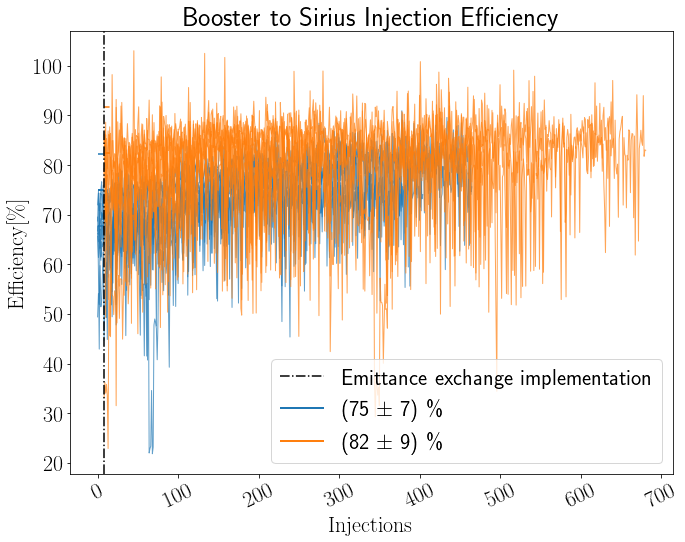

In [8]:
inj0 = inj0[-8:]

timestamp = inj0[0][1][0]
initdate = datetime.fromtimestamp(timestamp)
timestamp = inj1[-1][1][-1]
lastdate = datetime.fromtimestamp(timestamp)

median1, mean1, std1, min1, max1 = calc_stats_eff_series(inj0)
median2, mean2, std2, min2, max2 = calc_stats_eff_series(
    inj1 #+ inj2_fil + inj3  + inj4_fil
)

# mark e.e.
# emit_exch_date = date(2022, 3, 29)
emit_exch_indx = len(inj0)

label1 = f'({median1:.0f} ' + r'$\pm$' + f' {std1:.0f}) \%'
label2 = f'({median2:.0f} ' + r'$\pm$' + f' {std2:.0f}) \%'
 
_ = plt.figure(figsize=(10,8))
plot_series(inj0, 'C0', 0, by_date=False)
plot_series(inj1, 'C1', emit_exch_indx, by_date=False)

#plot statistics before e.e.
plt.hlines(median1 - std1, 0, emit_exch_indx, lw=1.5, ls='--', color='C0')
plt.hlines(median1, 0, emit_exch_indx, lw=2, ls='-', color='C0', label=label1)
plt.hlines(median1 + std1, 0, emit_exch_indx, lw=1.5, ls='--', color='C0')
 
#plot emittance exchange date
plt.axvline(emit_exch_indx, lw=1.5, ls='dashdot', color='k', label='Emittance exchange implementation')

end_indx = emit_exch_indx + len(inj1) 
#plot statistics after e.e.
plt.hlines(median2 - std2, emit_exch_indx, end_indx, lw=1.5, ls='--', color='C1')
plt.hlines(median2, emit_exch_indx, end_indx, lw=2, ls='-', color='C1', label=label2)
plt.hlines(median2 + std2, emit_exch_indx, end_indx, lw=1.5, ls='--', color='C1')
plt.xticks(rotation=25)
plt.xlabel(r'$\mathrm{Injections}$')
plt.ylabel(r'$\mathrm{Efficiency [\%]}$')

plt.legend(loc='best')
plt.title('Booster to Sirius Injection Efficiency')
plt.tight_layout()
plt.savefig('bo-si-efficiency_week_before_after.svg', dpi=300)
plt.show()

In [66]:
len(inj1[3][2])

674

Comparing the maximum of injections

In [142]:
inj_after = inj1 + inj2 + inj3

In [170]:
max_bef = [inj0[n][2].max() for n in range(len(inj0))]
max_bef /= np.max(max_aft)/ 100
max_aft = [inj_after[n][2].max() for n in range(len(inj_after))]
max_aft /= np.max(max_aft)/ 100

In [174]:
idx_before = np.arange(len(max_bef))
idx_after = np.arange(start=len(max_bef), stop= len(max_aft)+len(max_bef))
_ = plt.figure()
plt.plot(idx_before, max_bef, label='max eff before')
plt.plot(idx_after, max_aft, label='max eff after')
plt.grid(alpha=0.5, ls='--')
plt.title('Max of each injection')
plt.xlabel('Injection index')
plt.ylabel('Injection Efficiency')
plt.legend()
plt.show()
plt.savefig('bo-si-max-efficiency.svg', dpi=300)

Idea: compare just the days after machine study, when the injection system is optimized

# Emittance exchange 2

Comparison in relation to the emittance exchange 1

In [9]:
inj0 = get_injection_series(injections2_before, plot_flag=False)
inj1 = get_injection_series(injections2_after1, plot_flag=False)

In [ ]:
timestamp = inj0[0][1][0]
initdate = datetime.fromtimestamp(timestamp)
timestamp = inj1[-1][1][-1]
lastdate = datetime.fromtimestamp(timestamp)

median1, mean1, std1, min1, max1 = calc_stats_eff_series(inj0)
median2, mean2, std2, min2, max2 = calc_stats_eff_series(
    inj1 #+ inj2_fil + inj3  + inj4_fil
)

# mark e.e.
emit_exch2_date = date(2022, 4, 25)

label1 = f'({median1:.0f} ' + r'$\pm$' + f' {std1:.0f}) \%'
label2 = f'({median2:.0f} ' + r'$\pm$' + f' {std2:.0f}) \%'
 
_ = plt.figure(figsize=(10,8))
plot_series(inj0, 'C0', 0)
plot_series(inj1, 'C1', 0)


#plot statistics before e.e.
plt.hlines(median1 - std1, initdate, emit_exch2_date, lw=1.5, ls='--', color='C0')
plt.hlines(median1, initdate, emit_exch2_date, lw=2, ls='-', color='C0', label=label1)
plt.hlines(median1 + std1, initdate, emit_exch2_date, lw=1.5, ls='--', color='C0')

#plot emittance exchange date
plt.axvline(emit_exch2_date, lw=1.5, ls='dashdot', color='k', label='Emittance exchange implementation')

#plot statistics before e.e.
plt.hlines(median2 - std2, emit_exch2_date, lastdate, lw=1.5, ls='--', color='C1')
plt.hlines(median2, emit_exch2_date, lastdate, lw=2, ls='-', color='C1', label=label2)
plt.hlines(median2 + std2, emit_exch2_date, lastdate, lw=1.5, ls='--', color='C1')
plt.xticks(rotation=25)
plt.xlabel(r'$\mathrm{Injections}$')
plt.ylabel(r'$\mathrm{Efficiency [\%]}$')

plt.legend(loc='best')
plt.title('Booster to Sirius Injection Efficiency')
plt.tight_layout()
plt.savefig('bo-si-efficiency_week_before_after_emit2.svg', dpi=300)
plt.show()

Analyzing single optimized injections

In [19]:
# 20 April - 23 April (With emittance exchange 1)
inj_emit_exc2 = [
    (Time(2022, 4, 25, 21, 9, 0), Time(2022, 4, 25, 21, 10, 39)),   
]

inj_emit_exc1 = [
    (Time(2022, 4, 25, 21, 16, 50), Time(2022, 4, 25, 21, 18, 30)),
]

inj_old =[ 
    (Time(2022, 3, 22, 18, 27, 0), Time(2022, 3, 22, 18, 33, 0)), 
    (Time(2022, 4, 25, 21, 21, 19), Time(2022, 4, 25, 21, 22, 0)), 
]

In [20]:
inj1 = get_injection_series(inj_emit_exc1, plot_flag=False)
inj2 = get_injection_series(inj_emit_exc2, plot_flag=False)
inj_old = get_injection_series(inj_old, plot_flag=False)

median1, mean1, std1, min1, max1 = calc_stats_eff_series(inj1)
median2, mean2, std2, min2, max2 = calc_stats_eff_series(inj2)
median_old, mean_old, std_old, min_old, max_old = calc_stats_eff_series(inj_old)

In [21]:
print(f"No Emit exch.: {median_old} +/- {std_old}")
print(f"Emit exch. 1: {median1} +/- {std1}")
print(f"Emit exch. 2: {median2} +/- {std2}")

No Emit exch.: 86.57470770598479 +/- 7.243399538837764
Emit exch. 1: 96.42676360636898 +/- 10.851727613998671
Emit exch. 2: 95.94399659845318 +/- 12.192372836486793


In [22]:
mean1, mean2, mean_old

(93.44837101116407, 92.53606822627876, 85.13600949206845)

# Injection efficiency dependence with temperature

In [34]:
%matplotlib inline

In [160]:
colors = ['k', 'purple']
def plot_eff_vs_curr(pvs_list, t1, t2):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i, pv in enumerate(pvs_list):
        ts, value = get_data(pv, t1, t2)
        value=value[1:]
        ts = ts[1:]
#         t = (ts[1:] - ts[1])/60
        if 'CurrInfo' in pv:
            ax1.plot(ts, value, label=pv, c=colors[i])
        if 'Temp' in pv:
            ax2.plot(ts, value, label=pv)
        ax1.set_xlabel('Time [min]')
        ax1.set_ylabel('Eff. [\%]')
        ax2.set_ylabel('Temp [ºC]')
    ax2.grid(ls='--', alpha=0.8)
    fig.legend(loc='lower left', bbox_to_anchor = (1, 0.5))
    fig.suptitle(t1.ctime())
    plt.show()

In [41]:
pvs_list = ['SI-Glob:AP-CurrInfo:InjEff-Mon',
           'SI-Glob:AP-CurrInfo:Current-Mon',
           'TS-01:PU-EjeSG-ED:Temp-Mon',
           'TS-01:PU-EjeSG-BG:Temp-Mon',
           'TS-01:PU-EjeSF-ED:Temp-Mon',
           'TS-01:PU-EjeSF-BG:Temp-Mon'
          ]

## Some injections before the emittance exchange

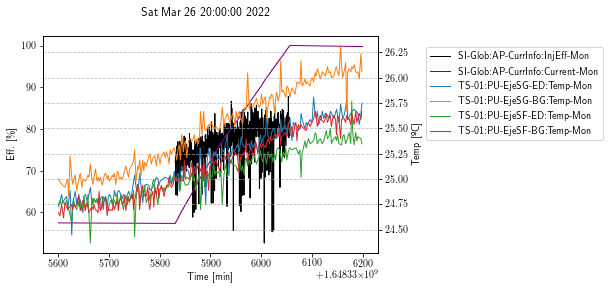

In [161]:
t1,t2=injections_before[-1]
plot_eff_vs_curr(pvs_list, t1, t2)

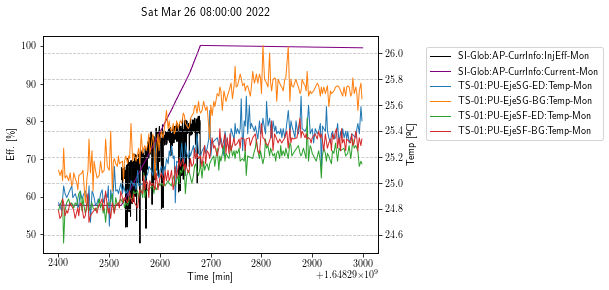

In [162]:
t1,t2=injections_before[-2]
plot_eff_vs_curr(pvs_list, t1, t2)

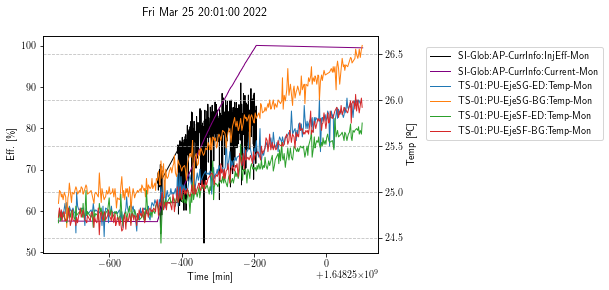

In [163]:
t1,t2=injections_before[-3]
plot_eff_vs_curr(pvs_list, t1, t2)

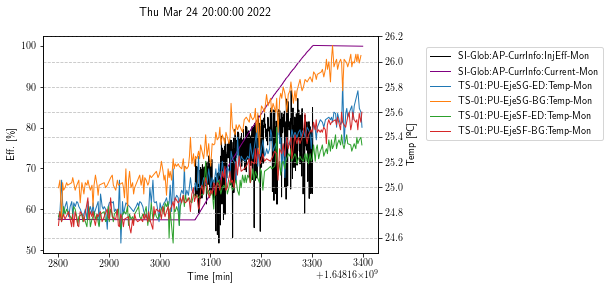

In [164]:
t1,t2=injections_before[-5]
plot_eff_vs_curr(pvs_list, t1, t2)

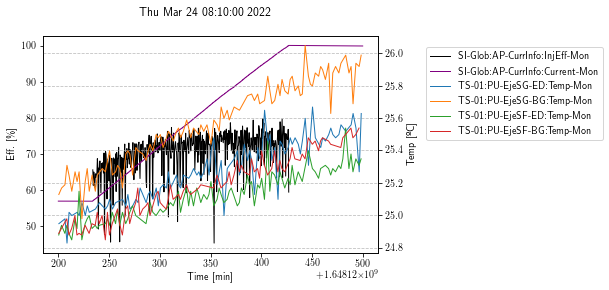

In [165]:
t1,t2=injections_before[-6]
plot_eff_vs_curr(pvs_list, t1, t2)

## After the emittance exchange

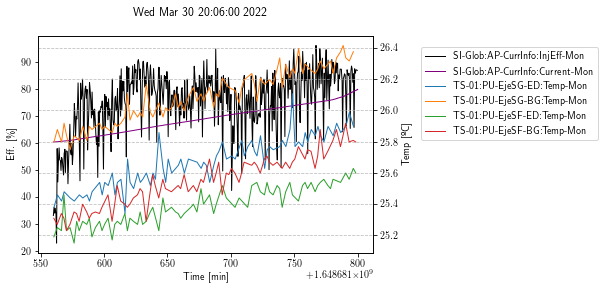

In [166]:
t1, t2 = injections_after1[0]
plot_eff_vs_curr(pvs_list, t1, t2)

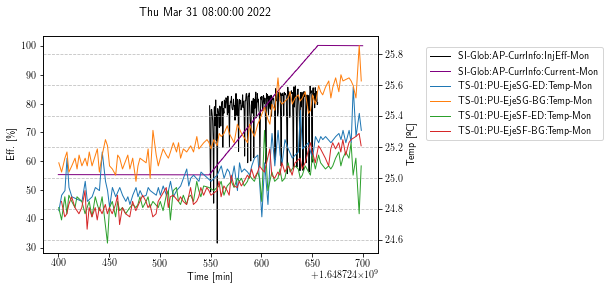

In [167]:
t1, t2 = injections_after1[1]
plot_eff_vs_curr(pvs_list, t1, t2)

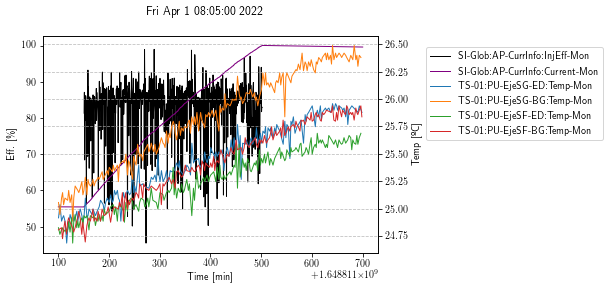

In [168]:
t1, t2 = injections_after1[3]
plot_eff_vs_curr(pvs_list, t1, t2)

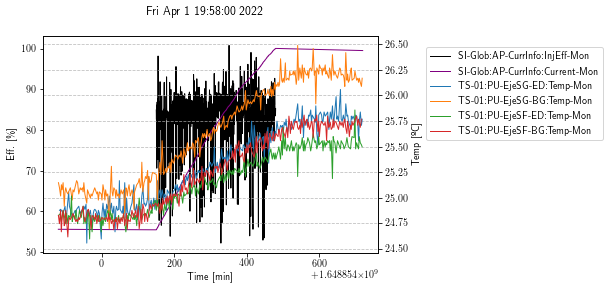

In [169]:
t1, t2 = injections_after1[4]
plot_eff_vs_curr(pvs_list, t1, t2)

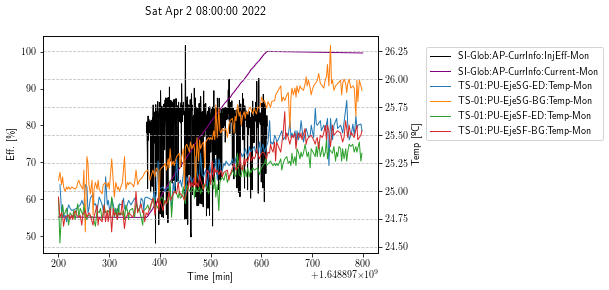

In [170]:
t1, t2 = injections_after1[5]
plot_eff_vs_curr(pvs_list, t1, t2)

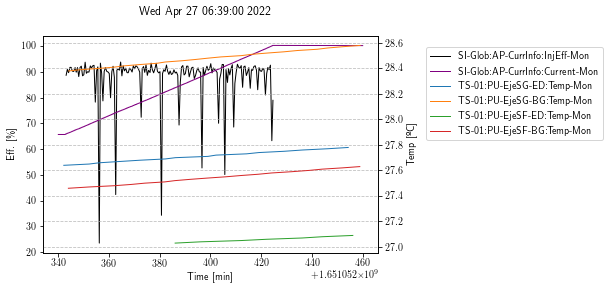

In [173]:
t1, t2 = injections2_after1[0]
plot_eff_vs_curr(pvs_list, t1, t2)

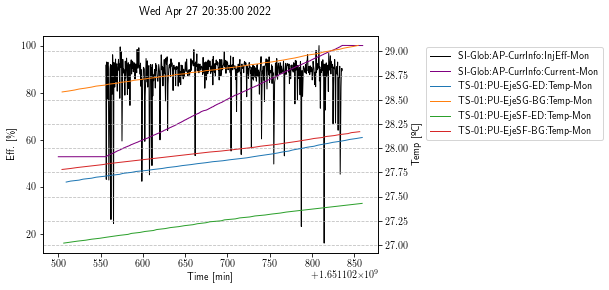

In [174]:
t1, t2 = injections2_after1[1]
plot_eff_vs_curr(pvs_list, t1, t2)

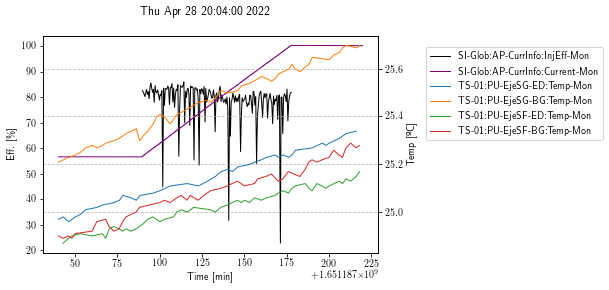

In [176]:
t1, t2 = injections2_after1[3]
plot_eff_vs_curr(pvs_list, t1, t2)